# Alternative baseline model with random forest

Uses the same preprocessed image input

## Model Choice

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score

# configuration
input_folder = "../3_Model/temp_processed_data_241208"                  # folder with preprocessed imagefiles
categories = ["with_seamount_manual1", "without_seamounts_manual1"]      # Subfolders in `image_folder` with catgeories

## Feature Selection

In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Function to determine the sample image size by picking one sample image from the folders
def get_first_image_size(input_folder, categories):
    for category in categories:
        category_folder = os.path.join(input_folder, category)
        if os.path.exists(category_folder) and os.path.isdir(category_folder):
            # List the files in the folder
            for file_name in os.listdir(category_folder):
                file_path = os.path.join(category_folder, file_name)
                if os.path.isfile(file_path):  # Ensure it's a file
                    image = cv2.imread(file_path)
                    if image is not None:
                        # Return the image size (height, width)
                        return image.shape[0], image.shape[1]  # Height and width
    return None, None  # if no image found

image_size = [0, 0]
image_size[0], image_size[1] = get_first_image_size(input_folder, categories)

print(f"Image sample size of {image_size[0]}x{image_size[1]} pixels!\n")

# Load processed dataset
def load_data(directory, categories):
    data, labels = [], []
    category_counts = {} 
    for label, category in enumerate(categories):
        category_folder = os.path.join(directory, category)
        file_count = 0
        for file_name in os.listdir(category_folder):
            file_path = os.path.join(category_folder, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                data.append(image.flatten())  # Flatten to vector for regression
                labels.append(label)
                file_count += 1
        category_counts[category] = file_count
    return np.array(data), np.array(labels), category_counts

data, labels, category_counts = load_data(input_folder, categories)

print("Number of samples per category:")
for category, count in category_counts.items():
    print(f"Category '{category}': {count} images")

# Function for balancing by undersampling
def balance_classes_undersample(X, y):
    unique_classes = np.unique(y)
    min_count = min([np.sum(y == cls) for cls in unique_classes])  # Smallest number per class
    X_balanced, y_balanced = [], []
    
    for cls in unique_classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        
        # Undersample the class to the minimum count
        X_undersampled, y_undersampled = resample(
            X_cls, y_cls, 
            replace=False,  # No replacement
            n_samples=min_count, 
            random_state=42
        )
        X_balanced.append(X_undersampled)
        y_balanced.append(y_undersampled)
    
    # Combine the classes back into one array
    return np.vstack(X_balanced), np.hstack(y_balanced)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print count of samples per class in training data
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("\nCount of samples per class in training data before undersampling:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

# Undersampling only needed on training data
X_train, y_train = balance_classes_undersample(X_train, y_train)

unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Count of samples per class in training data after undersampling:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

# Normalize pixel values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Image sample size of 128x128 pixels!

Number of samples per category:
Category 'with_seamount_manual1': 500 images
Category 'without_seamounts_manual1': 500 images

Count of samples per class in training data before undersampling:
Class 0: 350 samples
Class 1: 350 samples
Count of samples per class in training data after undersampling:
Class 0: 350 samples
Class 1: 350 samples


## Implementation

In [10]:
# Train Random Forest model
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

Training Random Forest Classifier...


RandomForestClassifier(random_state=42)

## Evaluation

Label Mapping in Training Data:
Label 0: with_seamount_manual1
Label 1: without_seamounts_manual1

Validation Results:
                           precision    recall  f1-score   support

    with_seamount_manual1       0.79      0.94      0.86        72
without_seamounts_manual1       0.94      0.77      0.85        78

                 accuracy                           0.85       150
                macro avg       0.86      0.86      0.85       150
             weighted avg       0.87      0.85      0.85       150

Validation Accuracy: 0.8533333333333334

Test Results:
                           precision    recall  f1-score   support

    with_seamount_manual1       0.82      0.92      0.87        78
without_seamounts_manual1       0.90      0.78      0.84        72

                 accuracy                           0.85       150
                macro avg       0.86      0.85      0.85       150
             weighted avg       0.86      0.85      0.85       150

Test Accuracy: 0

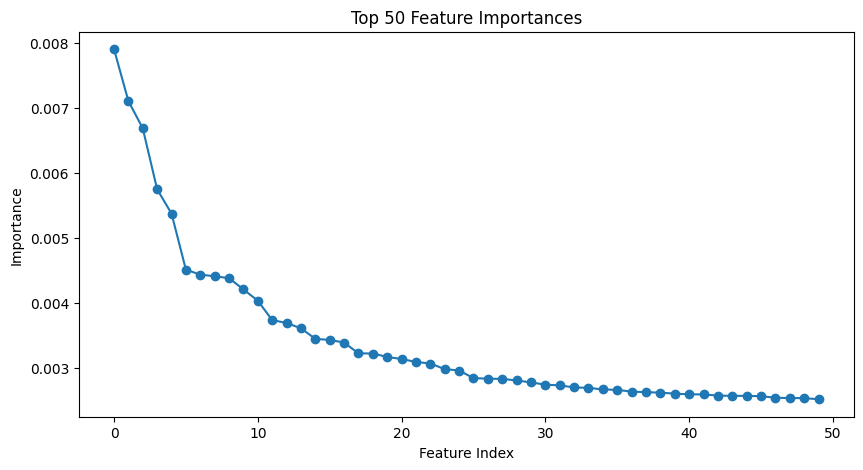

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Visualizing Predictions on Test Set:


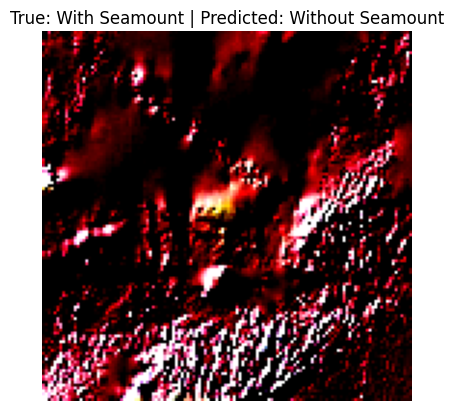

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


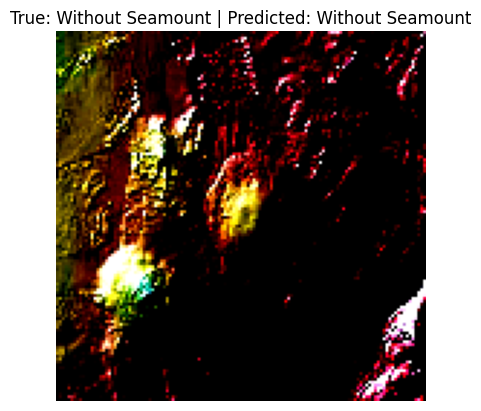

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


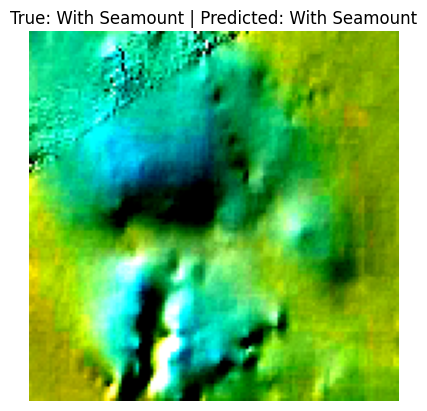

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


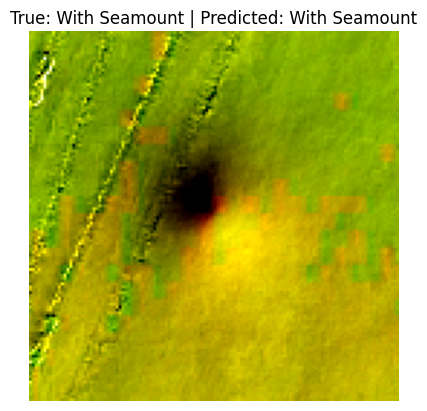

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


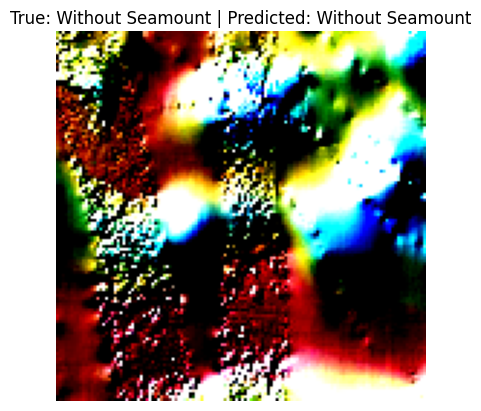

In [11]:
# show class mapping number to lable
unique_labels = np.unique(y_train)

print("Label Mapping in Training Data:")
for label in unique_labels:
    print(f"Label {label}: {categories[label]}")

# Evaluate model
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

print("\nValidation Results:")
print(classification_report(y_val, y_val_pred, target_names=categories))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

print("\nTest Results:")
print(classification_report(y_test, y_test_pred, target_names=categories))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Feature Importance (Optional)
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(10, 5))
plt.plot(np.sort(feature_importances)[::-1][:50], marker='o')
plt.title("Top 50 Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Visualize a few test images with predictions
def visualize_predictions(X, y_true, y_pred, num_images=5):
    indices = np.random.choice(len(X), num_images, replace=False)
    for i in indices:
        img = X[i].reshape(image_size[0], image_size[1], 3)  # Reshape to original image dimensions
        true_label = "With Seamount" if y_true[i] == 1 else "Without Seamount"
        predicted_label = "With Seamount" if y_pred[i] == 1 else "Without Seamount"
        
        plt.figure()
        plt.imshow(img)
        plt.title(f"True: {true_label} | Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

print("\nVisualizing Predictions on Test Set:")
visualize_predictions(X_test, y_test, y_test_pred, num_images=5)